<div style="border-left: 6px solid #2196F3; background: linear-gradient(to right, #33ccff, #8ee4ed); padding: 15px; margin-bottom: 20px; border-radius: 30px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <b style="color: #37294a; font-size: 30px; margin-bottom: 5px; display: block; text-decoration: underline;">A ClearScape Analytics Best Practice Recipe</b>
author: martin.hillebrand@teradata.com
</div>


<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
Create ONNX Model with SparkML
 <br>
       <img id="spark-logo" src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" alt="spark" style="padding: 4pt; background-color: white; width: 80px; height: auto; margin-top: 20pt;">     
<img id="onnx-logo" src="https://upload.wikimedia.org/wikipedia/commons/c/c0/ONNX_logo_main.png" alt="onnx" style="padding: 4pt; background-color: white; width: 125px; height: auto; margin-top: 20pt;"> 
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 150px; height: auto; margin-top: 20pt;">
  <br>
    </p>
</header>

<div style="display: flex; align-items: center; border-left: 6px solid #f54242; background: linear-gradient(to right, #f5e042, #f5ce42); padding: 15px; margin-bottom: 20px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <div style="color: red; font-size: 70px; padding-right: 15px;">❗</div>
    <div style="font-size: larger; font-weight: bold;">ATTENTION: This notebook only works when run in a <code>quay.io/jupyter/pyspark-notebook</code> docker container, because it requires a running spark cluster</div>
</div>


# Using SparkML for Model Training in a Locally Hosted Spark Environment

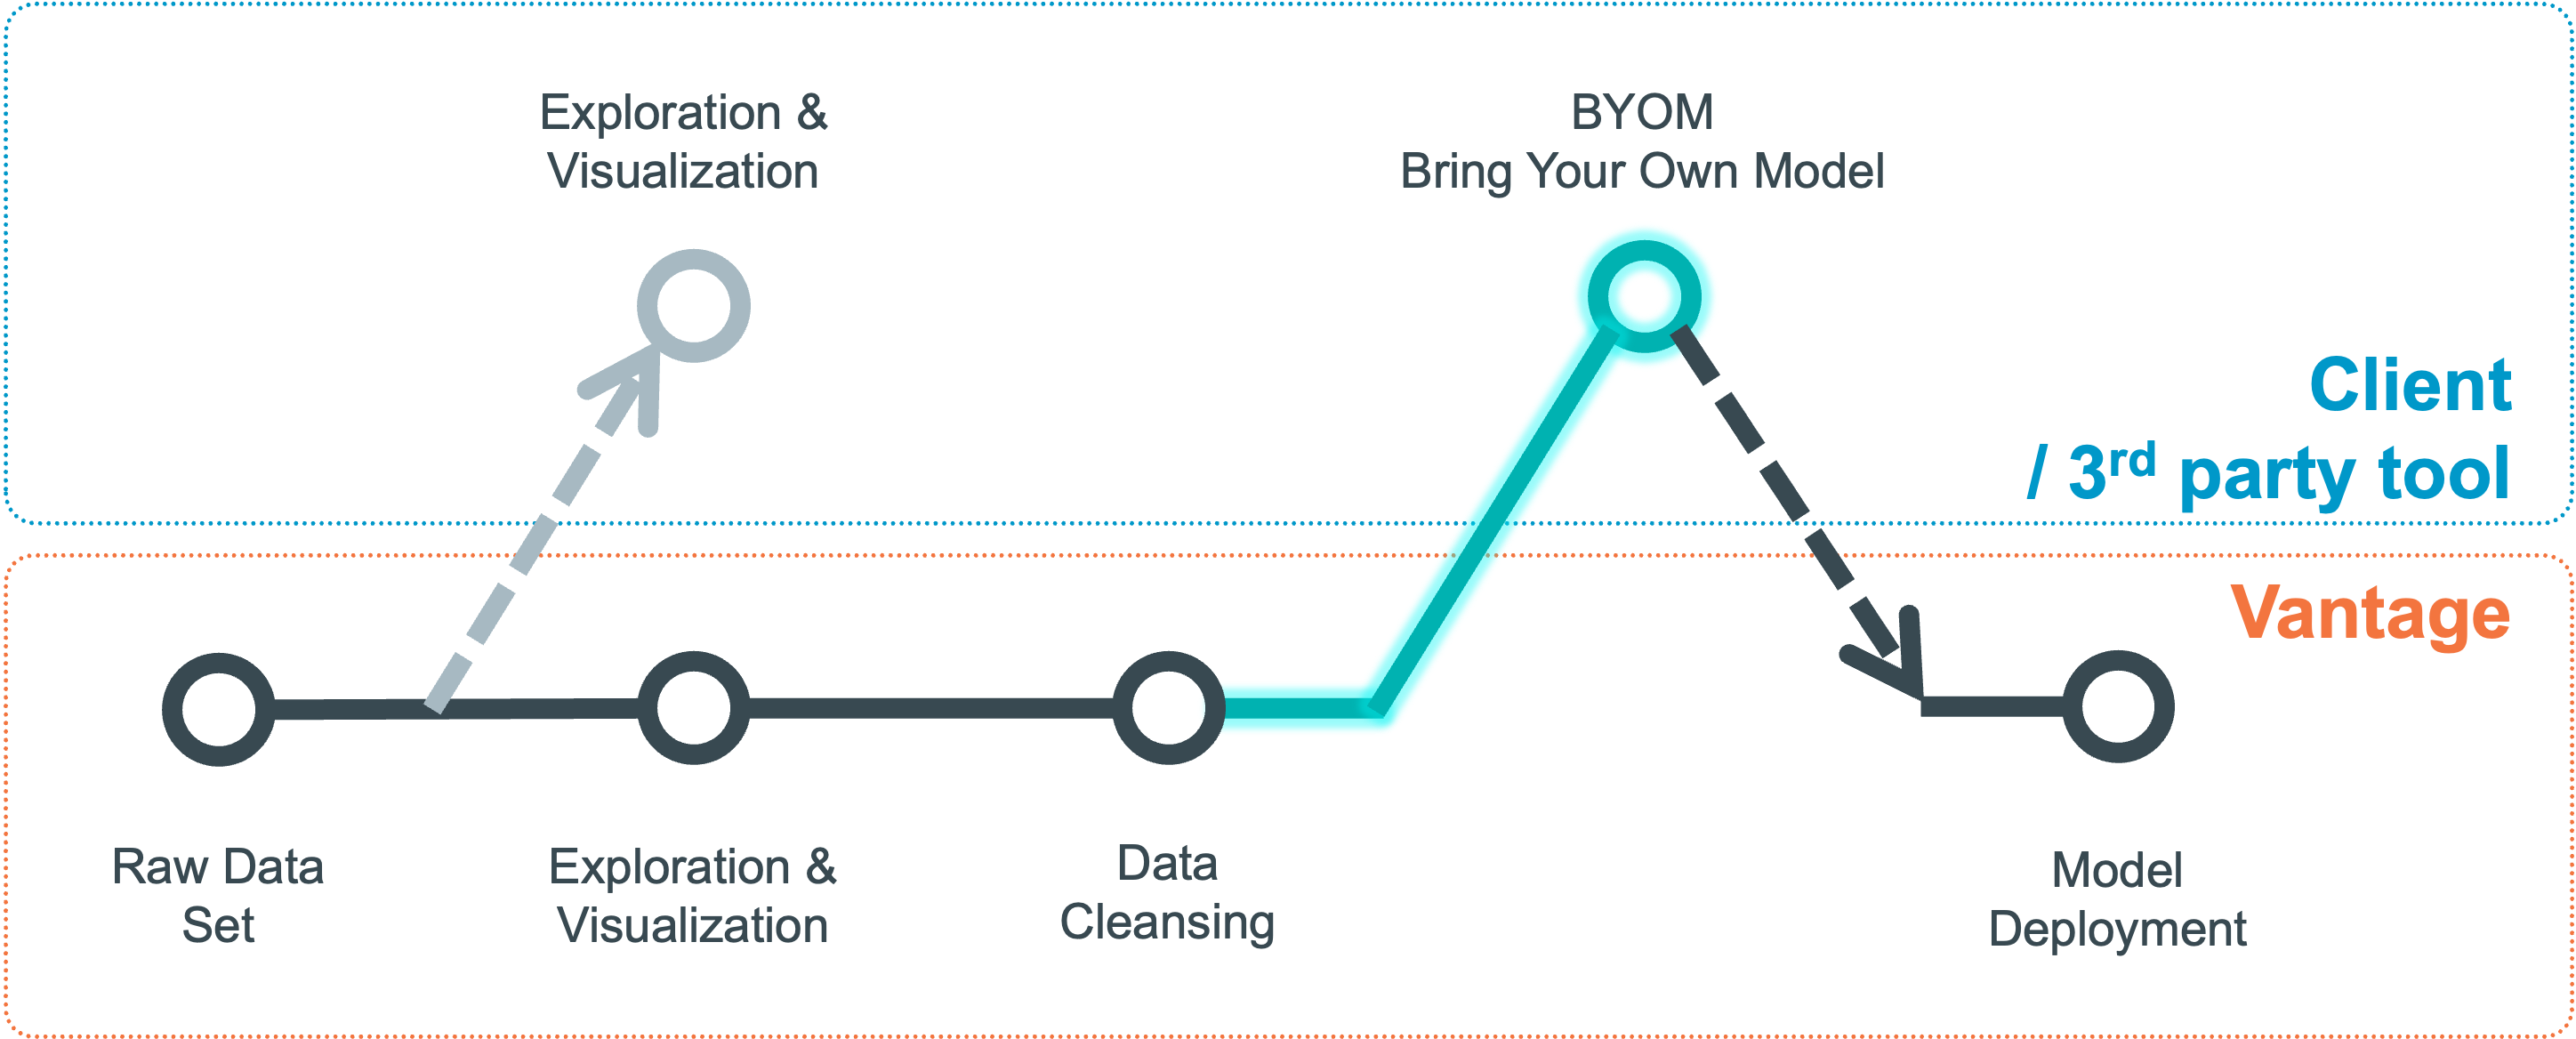

If you don't have access to a Spark cluster, you can set up a small instance on your local machine for demo purposes, using a docker container. Here are the steps:

- Install Docker (verify if your company requires a paid license).
- Retrieve the image `quay.io/jupyter/pyspark-notebook:latest` by executing the following command in your shell:
    - `docker pull quay.io/jupyter/pyspark-notebook`
- Start the container by executing the following command:
    - `docker run -it -p 8889:8888 -v <local_path>:/home/jovyan/work quay.io/jupyter/pyspark-notebook`
        - Replace `<local_path>` with the path to your working directory in your local file system.
        - Note: Port 8889 is used here because port 8888 was occupied. Ensure to use the port you have selected.
- Follow the instructions in your shell, oben jupyter lab from the container and execute the notebook with the model training using pyspark. Once you have trained the models and saved them, you can come back tho this notebook.

**The expected output of this notebooks are two files:**
- `rf_churn_sparkml.onnx`
- `rf_churn_sparkml_weights.onnx`

# Installation of Required Packages

In [1]:
try:
    import onnxmltools
except ImportError:
    !pip install onnxmltools
    import onnxmltools

In [2]:
try:
    import onnxconverter_common
except ImportError:
    !pip install onnxconverter_common
    import onnxconverter_common

In [3]:
try:
    import onnxruntime
except ImportError:
    !pip install onnxruntime
    import onnxruntime

In [4]:
from onnxmltools import convert_sparkml
from onnxmltools.convert.common.data_types import FloatTensorType
from onnxconverter_common.onnx_ex import DEFAULT_OPSET_NUMBER
from onnx.defs import onnx_opset_version

TARGET_OPSET = min(DEFAULT_OPSET_NUMBER, onnx_opset_version())

In [5]:
from onnxruntime import InferenceSession

In [6]:
import numpy as np
import pandas as pd

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import functions as F

# Set up Spark Session

In [8]:
# Spark session & context
spark = SparkSession.builder.master("local").getOrCreate()
sc = spark.sparkContext

In [9]:
# test that spark session is working
# Sum of the first 100 whole numbers
rdd = sc.parallelize(range(100 + 1))
rdd.sum()
# 5050

5050

# Load Data to Spark DataFrame

## Read from NOS

```python
df = spark.read.parquet(....)
```

## Alternative: Read from CSV

In [10]:
df = spark.read.csv("DF_ADS_training.csv", header=True, inferSchema=True)

In [11]:
#validate data types. We expect all floats (double) for features and ints for customerid and exited
df.dtypes

[('customerid', 'int'),
 ('exited', 'int'),
 ('academictitle_surname__MLB_1_Dr', 'double'),
 ('academictitle_surname__MLB_2_Prof', 'double'),
 ('creditscore', 'double'),
 ('geography__OHE_1_Spain', 'double'),
 ('geography__OHE_2_Germany', 'double'),
 ('geography__OHE_3_France', 'double'),
 ('geography__OHE_0_otherwise', 'double'),
 ('gender', 'double'),
 ('age', 'double'),
 ('tenure', 'double'),
 ('balance', 'double'),
 ('hascrcard', 'double'),
 ('isactivemember', 'double'),
 ('estimatedsalary', 'double'),
 ('bank_products__MLB_1_MortgageLoan', 'double'),
 ('bank_products__MLB_2_RetirementAccount', 'double'),
 ('bank_products__MLB_3_CreditCard', 'double'),
 ('bank_products__MLB_4_InvestmentFund', 'double'),
 ('bank_products__MLB_5_HomeEquityLoan', 'double'),
 ('bank_products__MLB_6_PersonalLoan', 'double'),
 ('bank_products__MLB_7_CheckingAccount', 'double'),
 ('bank_products__MLB_8_SavingsAccount', 'double'),
 ('bank_products__MLB_9_CertificateOfDeposit', 'double'),
 ('bank_products__

In [12]:
df.limit(5).toPandas()

,customerid,exited,academictitle_surname__MLB_1_Dr,academictitle_surname__MLB_2_Prof,creditscore,geography__OHE_1_Spain,geography__OHE_2_Germany,geography__OHE_3_France,geography__OHE_0_otherwise,gender,...,bank_products__MLB_1_MortgageLoan,bank_products__MLB_2_RetirementAccount,bank_products__MLB_3_CreditCard,bank_products__MLB_4_InvestmentFund,bank_products__MLB_5_HomeEquityLoan,bank_products__MLB_6_PersonalLoan,bank_products__MLB_7_CheckingAccount,bank_products__MLB_8_SavingsAccount,bank_products__MLB_9_CertificateOfDeposit,bank_products__MLB_10_AutoLoan
0,15803790,0,0.0,0.0,0.576,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,15748589,0,0.0,0.0,0.772,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,15806808,1,0.0,0.0,0.968,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,15706602,0,0.0,0.0,0.820,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,15809826,1,0.0,0.0,0.756,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
key = "customerid"
target = "exited"

In [14]:
# we need the features list for setting up the pipeline and for ONNX conversion
features = list(df.drop(key,target).columns)
num_features = len(features)
features

['academictitle_surname__MLB_1_Dr',
 'academictitle_surname__MLB_2_Prof',
 'creditscore',
 'geography__OHE_1_Spain',
 'geography__OHE_2_Germany',
 'geography__OHE_3_France',
 'geography__OHE_0_otherwise',
 'gender',
 'age',
 'tenure',
 'balance',
 'hascrcard',
 'isactivemember',
 'estimatedsalary',
 'bank_products__MLB_1_MortgageLoan',
 'bank_products__MLB_2_RetirementAccount',
 'bank_products__MLB_3_CreditCard',
 'bank_products__MLB_4_InvestmentFund',
 'bank_products__MLB_5_HomeEquityLoan',
 'bank_products__MLB_6_PersonalLoan',
 'bank_products__MLB_7_CheckingAccount',
 'bank_products__MLB_8_SavingsAccount',
 'bank_products__MLB_9_CertificateOfDeposit',
 'bank_products__MLB_10_AutoLoan']

# Modelling

## Model 1:  Random Forest **Without** Weights

<div style="border-left: 6px solid #2196F3; background: linear-gradient(to right, #33ccff, #8ee4ed); padding: 15px; margin-bottom: 20px; border-radius: 30px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <b style="color: #37294a; font-size: 30px; margin-bottom: 5px; display: block; text-decoration: underline;">Best Practice Tips</b>
    <ul style="list-style-type: none; padding: 0;">
        <li style="margin-bottom: 10px; display: flex; align-items: start;"><span style="color: #FFEB3B; font-size: 20px; line-height: 1.2;">💡</span><span style="margin-left: 8px;">
The value <code>"features"</code> in the <code>VectorAssembler</code> is not an arbitrary value, it must match the value for <code>ModelInputFieldsMap</code> you use in the <code>ONNXPredict()</code> 
        </span></li>
    </ul>
</div>


### Fit Model

In [15]:
vec_assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

data = vec_assembler.transform(df)

rf1 = RandomForestClassifier(
    labelCol=target, featuresCol="features", numTrees=5
)

model1 = rf1.fit(dataset=data)

### Export to ONNX

In [16]:
model_onnx1 = convert_sparkml(
    model1,
    "Churn",
    
    [("features", FloatTensorType([None, num_features]))],
    spark_session=spark,
    target_opset=TARGET_OPSET,
)

### Test ONNX Scoring

In [17]:
sess1 = InferenceSession(
    model_onnx1.SerializeToString(), providers=["CPUExecutionProvider"]
)

In [18]:
input_name = sess1.get_inputs()[0].name
label_name = sess1.get_outputs()[0].name
print(input_name, label_name)

features prediction


In [19]:
X = df.limit(100).toPandas()[features]

In [20]:
pred_onx = sess1.run(
    [label_name], 
    {input_name: X.astype(np.float32).values})[0]
print(pred_onx)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]


### Save Model File

In [21]:
model_filename1 = "rf_churn_sparkml.onnx"

In [22]:
with open(model_filename1, "wb") as f:
    f.write(model_onnx1.SerializeToString())

___

## Model 2:  Random Forest **With** Weights

### Add Weights to Data Based on Target Distribution

In [23]:
total_count = df.count()
churn_1 = df.filter(F.col(target) == 1).count()
churn_0 = total_count - churn_1

weight_1 = (total_count*1.0 / (2 * churn_1))
weight_0 = (total_count*1.0 / (2 * churn_0))

In [24]:
df_weights = df.withColumn(
    "WEIGHTS",
    F.when(F.col(target) == 1, weight_1).otherwise(weight_0)
)

### Fit Model

In [25]:
vec_assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

data = vec_assembler.transform(df_weights)

rf2 = RandomForestClassifier(
    labelCol=target, featuresCol="features", numTrees=5,
    weightCol="WEIGHTS"
)

model2 = rf2.fit(dataset=data)

### Export to ONNX

In [26]:
model_onnx2 = convert_sparkml(
    model2,
    "Churn_weights",
    
    [("features", FloatTensorType([None, num_features]))],
    spark_session=spark,
    target_opset=TARGET_OPSET,
)

### Test ONNX Scoring

In [27]:
sess2 = InferenceSession(
    model_onnx2.SerializeToString(), providers=["CPUExecutionProvider"]
)

In [28]:
input_name = sess2.get_inputs()[0].name
label_name = sess2.get_outputs()[0].name
print(input_name, label_name)

features prediction


In [29]:
X = df.limit(100).toPandas()[features]

In [30]:
pred_onx = sess2.run(
    [label_name], 
    {input_name: X.astype(np.float32).values})[0]
print(pred_onx)

[0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0
 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1
 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0]


### Save Model File

In [31]:
model_filename2 = "rf_churn_sparkml_weights.onnx"

In [32]:
with open(model_filename2, "wb") as f:
    f.write(model_onnx2.SerializeToString())

# close session

In [33]:
spark.stop()